# Quick start tutorial

This tutorial will cover how to compute false non-match rate and false match rate together with the confidence intervals of their estimates. 

In [1]:
import json
from cimat import MTData, UncertaintyEstimator
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
import matplotlib.cm as cm

Let's first generate synthetic data. 

In [2]:
# generate embeddings (here you would import your own embeddings)
G = 50 # number of identities
M = 10   # number of images per identity
D = 100 # embedding dimension
cluster_diameter = 0.2 # 0, 0.1, 0.3, 10 # diameter of the cloud of points corresponding to each identity

# generate data: the data is formatted as a dictionary of dictionaries with structure dictionary[id][image] = embedding
cluster_centers = {id: np.random.normal(0, 1, D) for id in range(G)} # cluster centers
cluster_centers = {id: cluster_centers[id] / np.linalg.norm(cluster_centers[id]) for id in range(G)} # normalize cluster centers
df = {id: {img: cluster_centers[id] + np.random.normal(0, cluster_diameter, D) for img in range(M)} for id in range(G)} # generate noise
df = {id: {img: df[id][img] / np.linalg.norm(df[id][img]) for img in range(M)} for id in range(G)} # normalize the embeddings to cast them onto the hypersphere


# plotting
if D==2:
    colors = cm.rainbow(np.linspace(0, 1, len(range(G))))
    plt.figure(figsize=(8, 6))
    for id, col in zip(df, colors):
        for img, vec in df[id].items():
            plt.scatter(vec[0], vec[1], color = col, label=f'ID {id}', alpha=0.7)
    plt.title('Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()

Now let's generate the similarity scores. 

In [3]:
# compute the pairwise similarities
mt = MTData(df)                  # class to store data and to transform them into similarity scores
mt.generate_similarity_scores()  # generate cosine similarity scores between images

Let's also visualize the distribution of the scores. 

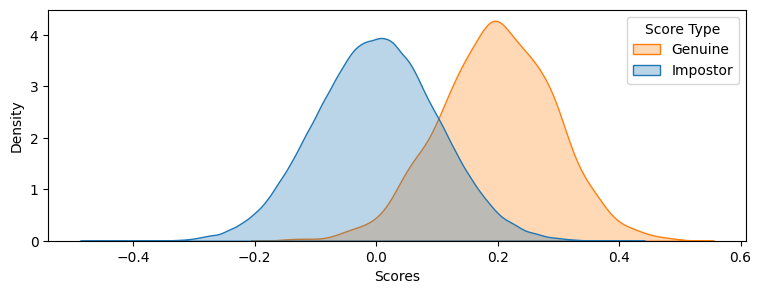

In [4]:
# instantiate the class for uncertainty estimation
uq = UncertaintyEstimator(scores=mt.similarity_scores) # structure is  dictionary[id1][id2] = [score, score, ...]

# gather scores and labels (0 is impostor score, 1 is genuine score)
scores, labels = uq.gather_scores()

# plot the densities of the scores conditionally on the label 
data= pd.DataFrame({'Score': scores, 'Label': labels})
plt.figure(figsize=(9,3))
sns.kdeplot(data=data, x='Score', hue='Label', fill=True, common_norm=False, hue_order=[0, 1], alpha=0.3)
#plt.yscale('log')
plt.xlabel('Scores')
plt.ylabel('Density')
plt.legend(title='Score Type', labels=['Genuine', 'Impostor'])
plt.show()

We then compute the FNMR and FMR at various decision thresholds. 

In [5]:
# set a threshold for determining matches versus non-matches
thresholds = np.arange(0,0.4,0.01)
fnmr_values = np.zeros(len(thresholds))
fmr_values = np.zeros(len(thresholds))
ci_FNMR = np.zeros((len(thresholds), 2))
ci_FMR = np.zeros((len(thresholds), 2))

alpha = 0.05

for i, threshold in tqdm(enumerate(thresholds)):
    # compute FNMR and FMR at each threshold
    fnmr_values[i], fmr_values[i], _ = uq.compute_binerror_metrics(threshold)
    # calculate 95% confidence intervals using the Wilson method with a plug-in estimator of the variance
    var_fnmr, var_fmr = uq.compute_variance(threshold=threshold, estimator="plugin")
    ci_FNMR[i], ci_FMR[i] = uq.get_binerror_ci(threshold, var_fnmr, var_fmr, alpha=alpha)

1it [00:00,  4.31it/s]

40it [00:09,  4.39it/s]


Let's look at the error rates for a given threshold. 

In [6]:
th = 0.15
print(f"Threshold: {th}")
ind = np.argmin([np.abs(thresholds - th)])
print(f"FNMR = {fnmr_values[ind]:.3f} with {100*(1-alpha):.0f}% CI = [{ci_FNMR[ind, 0]:.3f}, {ci_FNMR[ind, 1]:.3f}]")
print(f"FMR = {fmr_values[ind]:.3f} with {100*(1-alpha):.0f}% CI = [{ci_FMR[ind, 0]:.3f}, {ci_FMR[ind, 1]:.3f}]")

Threshold: 0.15
FNMR = 0.299 with 95% CI = [0.274, 0.325]
FMR = 0.068 with 95% CI = [0.066, 0.071]


If you have lots of data, computing the plug-in estimator at each threshold can be cumbersome. In this case, you can benefit from the bootstrap. The bootstrap is expensive to run but it only needs to be run once! Just keep in mind that (double-or-nothing) bootstrap intervals are generally conservative (when the metric is far from 0 or 1) thus they may be fairly wide. Let's see how to obtain them below. 

In [7]:
# # bootstrap
# uq.run_bootstrap(B=1000)

# for i, threshold in enumerate(thresholds):
#     var_fnmr_boot, var_fmr_boot = uq.compute_variance(threshold=threshold, estimator="boot")
#     ci_FNMR[i], ci_FMR[i] = uq.get_binerror_ci(threshold, var_fnmr_boot, var_fmr_boot, alpha=0.05)

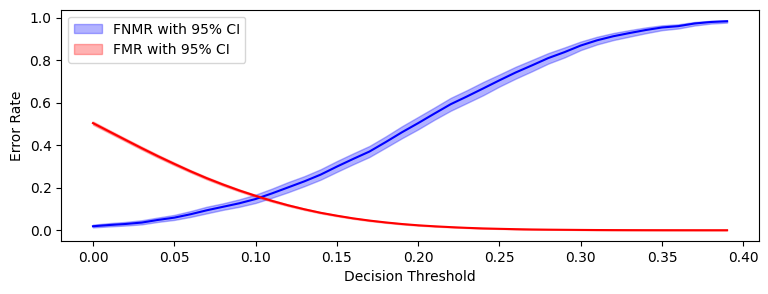

In [8]:
# plot error rates vs. decision thresholds
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(9, 3))
fnmr_line = ax.plot(thresholds, fnmr_values, color='blue')[0]
fmr_line = ax.plot(thresholds, fmr_values, color='red')[0]
ax.fill_between(thresholds, ci_FNMR[:, 0], ci_FNMR[:, 1], color='blue', alpha=0.3)
ax.fill_between(thresholds, ci_FMR[:, 0], ci_FMR[:, 1], color='red', alpha=0.3)
fnmr_legend = mpatches.Patch(color='blue', alpha=0.3, label='FNMR with 95% CI')
fmr_legend = mpatches.Patch(color='red', alpha=0.3, label='FMR with 95% CI')
ax.legend(handles=[fnmr_legend, fmr_legend], loc='best')
ax.set_xlabel('Decision Threshold')
ax.set_ylabel('Error Rate')
plt.show()

Finally, we obtain pointwise confidence intervals for the ROC with the bootstrap as well as the AUC. 

In [9]:
uq.run_bootstrap(B=1000) # first run the double-or-nothing bootstrap

100%|██████████| 1000/1000 [00:20<00:00, 47.98it/s]


AUC = 0.9238 with 90% CI = [0.9166, 0.930]


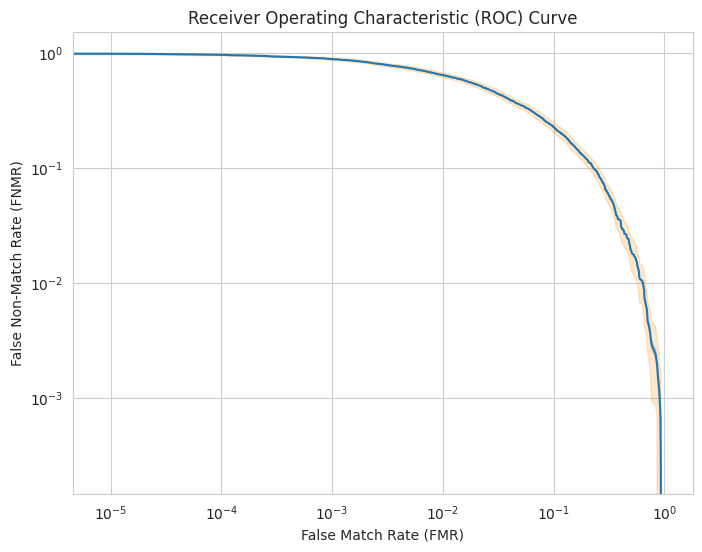

In [10]:
fmr, tmr, auc = uq.get_roc() # get the entire roc curve and the auc

# compute the intervals
alpha = 0.1
ci_ROC, ci_AUC = uq.get_roc_ci(alpha = alpha) # you MUST have run the bootstrap

print(f"AUC = {auc:.4f} with {100*(1-alpha):.0f}% CI = [{ci_AUC[0]:.4f}, {ci_AUC[1]:.3f}]")

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
sns.lineplot(x = "fmr", y = "fnmr", data = pd.DataFrame({"fmr": fmr, "fnmr": 1 - tmr}))
plt.fill_between(fmr, 1 - ci_ROC[1],1 - ci_ROC[0], alpha=0.2, color='darkorange', label='')
plt.xlabel('False Match Rate (FMR)')
plt.ylabel('False Non-Match Rate (FNMR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xscale('log')
plt.yscale('log')
plt.show()

We can also look at the values of FNMR @ FMR and its corresponding intervals. 

In [11]:
target_fmr = [0.001, 0.01, 0.1]
fmr, tmr, auc = uq.get_roc(target_fmr) # get the entire roc curve and the auc
ci_ROC, ci_AUC = uq.get_roc_ci(target_fmr, alpha) # you must have run the bootstrap before. If not, run uq.bootstrap(B=1000)

for i, target in enumerate(target_fmr):
    print(f"FNMR @ FMR = {target} is {1 - tmr[i]:.3f} with {100*(1-alpha):.0f}% CI = {1 - ci_ROC[1][i]:.3f}, {1 - ci_ROC[0][i]:.3f}")

FNMR @ FMR = 0.001 is 0.888 with 90% CI = 0.864, 0.910
FNMR @ FMR = 0.01 is 0.644 with 90% CI = 0.613, 0.673
FNMR @ FMR = 0.1 is 0.228 with 90% CI = 0.204, 0.251
